In [1]:
import os
import re
import csv
import joblib
import datetime
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import geodesic

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

from scipy.stats import randint, uniform

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv("CommercialTransaction20250917124317.csv")
df.head()

,Project Name,Street Name,Property Type,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Type of Area,Area (SQM),Unit Price ($ PSM),Tenure,Postal District,Floor Level
0,N.A.,LORONG 25A GEYLANG,Shop House,"1,400,000.00","1,033.34","1,355",Sept-25,Strata,96,"14,583",Freehold,14,-
1,KAMPONG GLAM CONSERVATION AREA,BUSSORAH STREET,Shop House,"6,350,000.00","1,558.63","4,074",Sept-25,Land,144.8,"43,854",99 yrs lease commencing from 2003,7,-
2,N.A.,TOH AVENUE,Shop House,"2,000,000.00","1,703.94","1,174",Aug-25,Land,158.3,"12,634",Freehold,17,-
3,N.A.,CEYLON ROAD,Shop House,"3,850,000.00","1,371.33","2,807",Aug-25,Land,127.4,"30,220",Freehold,15,-
4,N.A.,CLOVER WAY,Shop House,"4,200,000.00","1,767.45","2,376",Aug-25,Land,164.2,"25,579",Freehold,20,-


In [3]:
import pandas as pd
import numpy as np
import re

def clean_transaction_data(df):
    # Create a copy to avoid modifying the original
    df_clean = df.copy()
    
    # 1. Clean 'Transacted Price ($)' - remove commas and convert to float
    df_clean['Transacted Price ($)'] = (
        df_clean['Transacted Price ($)']
        .str.replace(',', '')
        .astype(float)
    )
    
    # 2. Clean 'Area (SQFT)' and 'Area (SQM)' - ensure they're numeric
    df_clean['Area (SQFT)'] = pd.to_numeric(df_clean['Area (SQFT)'], errors='coerce')
    df_clean['Area (SQM)'] = pd.to_numeric(df_clean['Area (SQM)'], errors='coerce')
    
    # 3. Clean 'Unit Price ($ PSF)' and 'Unit Price ($ PSM)' - remove commas, convert to float
    df_clean['Unit Price ($ PSF)'] = (
        df_clean['Unit Price ($ PSF)']
        .astype(str).str.replace(',', '')
        .astype(float)
    )
    
    df_clean['Unit Price ($ PSM)'] = (
        df_clean['Unit Price ($ PSM)']
        .astype(str).str.replace(',', '')
        .astype(float)
    )
    
    # 4. Convert 'Sale Date' to datetime (handling 'Sept-25' format)
    df_clean['Sale Date'] = pd.to_datetime(df_clean['Sale Date'], format='%b-%y', errors='coerce')
    

    
    return df_clean

# Apply the cleaning function
df = clean_transaction_data(df)



In [4]:
df.isnull().sum()

Project Name               0
Street Name                0
Property Type              0
Transacted Price ($)       0
Area (SQFT)             1068
Unit Price ($ PSF)         0
Sale Date                236
Type of Area               0
Area (SQM)                53
Unit Price ($ PSM)         0
Tenure                     1
Postal District            0
Floor Level                0
dtype: int64

In [5]:
df.dtypes

Project Name                    object
Street Name                     object
Property Type                   object
Transacted Price ($)           float64
Area (SQFT)                    float64
Unit Price ($ PSF)             float64
Sale Date               datetime64[ns]
Type of Area                    object
Area (SQM)                     float64
Unit Price ($ PSM)             float64
Tenure                          object
Postal District                  int64
Floor Level                     object
dtype: object

In [6]:
df.head()

,Project Name,Street Name,Property Type,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Type of Area,Area (SQM),Unit Price ($ PSM),Tenure,Postal District,Floor Level
0,N.A.,LORONG 25A GEYLANG,Shop House,1400000.0,NaN,1355.0,NaT,Strata,96.0,14583.0,Freehold,14,-
1,KAMPONG GLAM CONSERVATION AREA,BUSSORAH STREET,Shop House,6350000.0,NaN,4074.0,NaT,Land,144.8,43854.0,99 yrs lease commencing from 2003,7,-
2,N.A.,TOH AVENUE,Shop House,2000000.0,NaN,1174.0,2025-08-01,Land,158.3,12634.0,Freehold,17,-
3,N.A.,CEYLON ROAD,Shop House,3850000.0,NaN,2807.0,2025-08-01,Land,127.4,30220.0,Freehold,15,-
4,N.A.,CLOVER WAY,Shop House,4200000.0,NaN,2376.0,2025-08-01,Land,164.2,25579.0,Freehold,20,-


# Removing null values

In [8]:
df['Project Name']=df['Project Name'].replace('N.A.', np.nan)

In [9]:
##remove rows with more than 3 missing values 

missing_counts = df.isnull().sum(axis=1)
print("Missing counts per row:\n", missing_counts)

missing_counts = df.isna().sum(axis=1)  # Count missing values per row
df.drop(df[missing_counts >= 3].index, inplace=True)

Missing counts per row:
 0       3
1       2
2       2
3       2
4       2
       ..
2949    0
2950    0
2951    0
2952    1
2953    0
Length: 2954, dtype: int64


## Target column by column:

In [11]:
##project name

df['Project Name'].unique()
most_frequent_value =df['Project Name'].mode()[0]
# Fill NaN values in the 'category' column with the most frequent value
df['Project Name'].fillna(most_frequent_value, inplace=True)

C:\Users\Zafee\AppData\Local\Temp\ipykernel_29584\6328051.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Project Name'].fillna(most_frequent_value, inplace=True)


In [12]:
##area SQFT

df['Area (SQFT)'].unique()
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df[['Area (SQFT)']] = imputer.fit_transform(df[['Area (SQFT)']])


In [13]:
##area SQM

df['Area (SQM)'].unique()
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df[['Area (SQM)']] = imputer.fit_transform(df[['Area (SQM)']])

In [14]:
## sale date

df['Sale Date'].unique()

df['sale_date_missing'] = df['Sale Date'].isna().astype(int)

df['sale_year'] = df['Sale Date'].dt.year
df['sale_month'] = df['Sale Date'].dt.month
df['sale_quarter'] = df['Sale Date'].dt.quarter
df['sale_dayofweek'] = df['Sale Date'].dt.dayofweek   # 0=Mon, 6=Sun

# continuous trend feature
df['days_since_first_sale'] = (df['Sale Date'] - df['Sale Date'].min()).dt.days

df.drop(columns=['Sale Date'], inplace=True)

In [15]:
## Tenure
df = df.dropna(subset=['Tenure'])

## Floor level according to property type: shop hse

In [17]:
df['Floor Level'].value_counts().get('-',0)

591

In [18]:
df['Floor Level'] =df['Floor Level'].replace('-', np.nan)

In [19]:
null_col1_rows = df[df['Floor Level'].isnull() & (df['Property Type']=='Shop House')]
print("Rows where 'col1' is null:")
null_col1_rows

Rows where 'col1' is null:


,Project Name,Street Name,Property Type,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Type of Area,Area (SQM),Unit Price ($ PSM),Tenure,Postal District,Floor Level,sale_date_missing,sale_year,sale_month,sale_quarter,sale_dayofweek,days_since_first_sale
1,KAMPONG GLAM CONSERVATION AREA,BUSSORAH STREET,Shop House,6350000.0,496.618271,4074.0,Land,144.8,43854.0,99 yrs lease commencing from 2003,7,NaN,1,NaN,NaN,NaN,NaN,NaN
2,LITTLE INDIA CONSERVATION AREA,TOH AVENUE,Shop House,2000000.0,496.618271,1174.0,Land,158.3,12634.0,Freehold,17,NaN,0,2025.0,8.0,3.0,4.0,1400.0
3,LITTLE INDIA CONSERVATION AREA,CEYLON ROAD,Shop House,3850000.0,496.618271,2807.0,Land,127.4,30220.0,Freehold,15,NaN,0,2025.0,8.0,3.0,4.0,1400.0
4,LITTLE INDIA CONSERVATION AREA,CLOVER WAY,Shop House,4200000.0,496.618271,2376.0,Land,164.2,25579.0,Freehold,20,NaN,0,2025.0,8.0,3.0,4.0,1400.0
5,LITTLE INDIA CONSERVATION AREA,ROWELL ROAD,Shop House,5270000.0,496.618271,5037.0,Land,97.2,54218.0,Freehold,8,NaN,0,2025.0,8.0,3.0,4.0,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,BOAT QUAY CONSERVATION AREA,CIRCULAR ROAD,Shop House,9500000.0,496.618271,9184.0,Land,96.1,98855.0,999 yrs lease commencing from 1826,1,NaN,0,2021.0,10.0,4.0,4.0,0.0
2519,KRETA AYER CONSERVATION AREA,PAGODA STREET,Shop House,13300000.0,496.618271,10782.0,Land,114.6,116056.0,Freehold,1,NaN,0,2021.0,10.0,4.0,4.0,0.0
2520,TELOK AYER CONSERVATION AREA,TELOK AYER STREET,Shop House,16800000.0,496.618271,11570.0,Land,134.9,124537.0,Freehold,1,NaN,1,NaN,NaN,NaN,NaN,NaN
2521,TELOK AYER CONSERVATION AREA,TELOK AYER STREET,Shop House,8550000.0,769.630000,11109.0,Land,71.5,119580.0,999 yrs lease commencing from 1827,1,NaN,1,NaN,NaN,NaN,NaN,NaN


In [20]:
##shop hse
df.loc[
    df['Floor Level'].isnull() & (df['Property Type'] == 'Shop House'),
    'Floor Level'
] = 0

In [21]:
ull_col1_rows = df[df['Floor Level'].notna() & (df['Property Type']=='Shop House')]
print("Rows where 'col1' is null:")
ull_col1_rows

Rows where 'col1' is null:


,Project Name,Street Name,Property Type,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Type of Area,Area (SQM),Unit Price ($ PSM),Tenure,Postal District,Floor Level,sale_date_missing,sale_year,sale_month,sale_quarter,sale_dayofweek,days_since_first_sale
1,KAMPONG GLAM CONSERVATION AREA,BUSSORAH STREET,Shop House,6350000.0,496.618271,4074.0,Land,144.8,43854.0,99 yrs lease commencing from 2003,7,0,1,NaN,NaN,NaN,NaN,NaN
2,LITTLE INDIA CONSERVATION AREA,TOH AVENUE,Shop House,2000000.0,496.618271,1174.0,Land,158.3,12634.0,Freehold,17,0,0,2025.0,8.0,3.0,4.0,1400.0
3,LITTLE INDIA CONSERVATION AREA,CEYLON ROAD,Shop House,3850000.0,496.618271,2807.0,Land,127.4,30220.0,Freehold,15,0,0,2025.0,8.0,3.0,4.0,1400.0
4,LITTLE INDIA CONSERVATION AREA,CLOVER WAY,Shop House,4200000.0,496.618271,2376.0,Land,164.2,25579.0,Freehold,20,0,0,2025.0,8.0,3.0,4.0,1400.0
5,LITTLE INDIA CONSERVATION AREA,ROWELL ROAD,Shop House,5270000.0,496.618271,5037.0,Land,97.2,54218.0,Freehold,8,0,0,2025.0,8.0,3.0,4.0,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,BOAT QUAY CONSERVATION AREA,CIRCULAR ROAD,Shop House,9500000.0,496.618271,9184.0,Land,96.1,98855.0,999 yrs lease commencing from 1826,1,0,0,2021.0,10.0,4.0,4.0,0.0
2519,KRETA AYER CONSERVATION AREA,PAGODA STREET,Shop House,13300000.0,496.618271,10782.0,Land,114.6,116056.0,Freehold,1,0,0,2021.0,10.0,4.0,4.0,0.0
2520,TELOK AYER CONSERVATION AREA,TELOK AYER STREET,Shop House,16800000.0,496.618271,11570.0,Land,134.9,124537.0,Freehold,1,0,1,NaN,NaN,NaN,NaN,NaN
2521,TELOK AYER CONSERVATION AREA,TELOK AYER STREET,Shop House,8550000.0,769.630000,11109.0,Land,71.5,119580.0,999 yrs lease commencing from 1827,1,0,1,NaN,NaN,NaN,NaN,NaN


## Floor level according to property type:retail

In [23]:
null_col1_rows = df[df['Floor Level'].isnull() & (df['Property Type']=='Retail')]
print("Rows where 'col1' is null:")
null_col1_rows

Rows where 'col1' is null:


,Project Name,Street Name,Property Type,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Type of Area,Area (SQM),Unit Price ($ PSM),Tenure,Postal District,Floor Level,sale_date_missing,sale_year,sale_month,sale_quarter,sale_dayofweek,days_since_first_sale
548,LITTLE INDIA CONSERVATION AREA,CHANGI ROAD,Retail,3000000.0,496.618271,2403.0,Strata,116.000000,25862.0,Freehold,14,NaN,0,2025.0,7.0,3.0,1.0,1369.0
550,ENG AUN MANSION,THOMSON ROAD,Retail,3000000.0,496.618271,2362.0,Strata,118.000000,25424.0,Freehold,11,NaN,0,2025.0,7.0,3.0,1.0,1369.0
553,LITTLE INDIA CONSERVATION AREA,UPPER PAYA LEBAR ROAD,Retail,4500000.0,496.618271,3344.0,Strata,125.000000,36000.0,Freehold,19,NaN,0,2025.0,7.0,3.0,1.0,1369.0
610,JK BUILDING,JALAN JURONG KECHIL,Retail,2358000.0,496.618271,2235.0,Strata,98.000000,24061.0,Freehold,21,NaN,0,2025.0,4.0,2.0,1.0,1278.0
621,R66 APARTMENTS,RANGOON ROAD/TESSENSOHN ROAD,Retail,16700000.0,496.618271,3301.0,Strata,470.000000,35532.0,Freehold,8,NaN,0,2025.0,3.0,1.0,5.0,1247.0
622,LITTLE INDIA CONSERVATION AREA,LORONG MAMBONG,Retail,7600000.0,496.618271,3315.0,Strata,213.000000,35681.0,Freehold,10,NaN,0,2025.0,3.0,1.0,5.0,1247.0
635,LITTLE INDIA CONSERVATION AREA,KINTA ROAD,Retail,6000000.0,496.618271,5209.0,Strata,107.000000,56075.0,Freehold,8,NaN,0,2025.0,2.0,1.0,5.0,1219.0
687,LITTLE INDIA CONSERVATION AREA,ENG KONG TERRACE,Retail,1800000.0,496.618271,1442.0,Strata,116.000000,15517.0,999 yrs lease commencing from 1994,21,NaN,0,2024.0,11.0,4.0,4.0,1127.0
840,LITTLE INDIA CONSERVATION AREA,TAMPINES AVENUE,Retail,1150000.0,496.618271,594.0,Strata,180.000000,6389.0,99 yrs lease commencing from 1953,18,NaN,0,2024.0,4.0,2.0,0.0,913.0
849,LITTLE INDIA CONSERVATION AREA,FLANDERS SQUARE,Retail,1550000.0,496.618271,1099.0,Strata,131.000000,11832.0,Freehold,8,NaN,0,2024.0,3.0,1.0,4.0,882.0


In [24]:
ull_col1_rows = df[df['Floor Level'].notna() & (df['Property Type']=='Retail')]
print("Rows where 'col1' is null:")
ull_col1_rows

Rows where 'col1' is null:


,Project Name,Street Name,Property Type,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Type of Area,Area (SQM),Unit Price ($ PSM),Tenure,Postal District,Floor Level,sale_date_missing,sale_year,sale_month,sale_quarter,sale_dayofweek,days_since_first_sale
504,LE REGAL,GEYLANG ROAD,Retail,310000.0,107.640000,2880.0,Strata,10.0,31000.0,Freehold,14,01 to 05,1,NaN,NaN,NaN,NaN,NaN
505,EAST VILLAGE,UPPER CHANGI ROAD,Retail,337615.0,107.640000,3137.0,Strata,10.0,33762.0,Freehold,16,01 to 05,1,NaN,NaN,NaN,NaN,NaN
506,BUKIT TIMAH SHOPPING CENTRE,UPPER BUKIT TIMAH ROAD,Retail,1100000.0,365.980000,3006.0,Strata,34.0,32353.0,999 yrs lease commencing from 1883,21,01 to 05,1,NaN,NaN,NaN,NaN,NaN
507,ROXY SQUARE,EAST COAST ROAD,Retail,620000.0,182.990000,3388.0,Strata,17.0,36471.0,9999 yrs lease commencing from 1980,15,01 to 05,1,NaN,NaN,NaN,NaN,NaN
508,CITY GATE,BEACH ROAD,Retail,1090000.0,409.030000,2665.0,Strata,38.0,28684.0,99 yrs lease commencing from 2014,7,01 to 05,0,2025.0,8.0,3.0,4.0,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,OXLEY TOWER,ROBINSON ROAD,Retail,1250000.0,365.980000,3416.0,Strata,34.0,36765.0,Freehold,1,01 to 05,0,2021.0,12.0,4.0,2.0,61.0
2950,OXLEY TOWER,ROBINSON ROAD,Retail,528000.0,161.460000,3270.0,Strata,15.0,35200.0,Freehold,1,01 to 05,0,2021.0,12.0,4.0,2.0,61.0
2951,PEOPLE'S PARK COMPLEX,PARK ROAD,Retail,900000.0,312.160000,2883.0,Strata,29.0,31034.0,99 yrs lease commencing from 1968,1,01 to 05,0,2021.0,11.0,4.0,0.0,31.0
2952,PLUS,CECIL STREET,Retail,3785060.0,496.618271,2980.0,Strata,118.0,32077.0,99 yrs lease commencing from 1989,1,06 to 10,0,2021.0,11.0,4.0,0.0,31.0


## fill in null values for floor level using imputation based off other features

In [26]:
def smart_floor_imputation(row, df):
    if pd.notna(row['Floor Level']):
        return row['Floor Level']
    
    # Try different levels of similarity
    similar_criteria = [
        # Level 1: Same Property Type + Postal District + Area Bin
        {'prop_type': row['Property Type'], 'postal_district': row['Postal District'], 'area_bin': row.get('Area_Bin', 'Unknown')},
        # Level 2: Same Property Type + Postal District
        {'prop_type': row['Property Type'], 'postal_district': row['Postal District']},
        # Level 3: Same Property Type only
        {'prop_type': row['Property Type']},
        # Level 4: Global most common
        {'global': True}
    ]
    
    for criteria in similar_criteria:
        if 'global' in criteria:
            # Global most common floor level
            most_common = df[df['Floor Level'].notna()]['Floor Level'].mode()
            if not most_common.empty:
                return most_common.iloc[0]
        
        elif 'area_bin' in criteria:
            # Check if Area_Bin column exists, if not skip this level
            if 'Area_Bin' not in df.columns:
                continue
            mask = (
                (df['Property Type'] == criteria['prop_type']) &
                (df['Postal District'] == criteria['postal_district']) &
                (df['Area_Bin'] == criteria['area_bin']) &
                (df['Floor Level'].notna())
            )
        elif 'postal_district' in criteria:
            mask = (
                (df['Property Type'] == criteria['prop_type']) &
                (df['Postal District'] == criteria['postal_district']) &
                (df['Floor Level'].notna())
            )
        else:
            # Only property type
            mask = (
                (df['Property Type'] == criteria['prop_type']) &
                (df['Floor Level'].notna())
            )
        
        similar_floors = df[mask]['Floor Level']
        if len(similar_floors) > 0:
            return similar_floors.mode().iloc[0]
    
    # Final fallback
    return '01 to 05'  # Most common default

# Apply smart imputation
df['Floor Level'] = df.apply(
    lambda row: smart_floor_imputation(row, df), axis=1
)

### Binning for floor levels

In [28]:
# Create both numerical and categorical features
def extract_floor_features(floor_str):
    """
    Extract multiple numerical features from floor ranges
    """
    if pd.isna(floor_str) or floor_str == '-' or floor_str == '0':
        return np.nan, np.nan, np.nan, 0, 0  # Added is_ground flag
    
    floor_str = str(floor_str).strip()
    
    # Handle ground floor (0)
    if floor_str == '0':
        return 0, 0, 0, 0, 1  # low, high, midpoint, is_basement, is_ground
    
    numbers = re.findall(r'\d+', floor_str)
    
    if not numbers:
        return np.nan, np.nan, np.nan, 0, 0
    
    is_basement = 1 if floor_str.startswith('B') else 0
    is_ground = 0  # Default not ground floor
    
    if len(numbers) >= 2:
        low = int(numbers[0])
        high = int(numbers[1])
        return low, high, (low + high) / 2, is_basement, is_ground
    else:
        num = int(numbers[0])
        return num, num, num, is_basement, is_ground

# Apply numerical feature extraction
floor_features = df['Floor Level'].apply(extract_floor_features)
df['Floor_Low'] = [x[0] for x in floor_features]
df['Floor_High'] = [x[1] for x in floor_features]
df['Floor_Midpoint'] = [x[2] for x in floor_features]
df['Is_Basement'] = [x[3] for x in floor_features]
df['Is_Ground'] = [x[4] for x in floor_features]  # New column

# Create ML-ready categories (updated to handle ground floor)
def create_ml_categories(floor_str):
    if pd.isna(floor_str) or floor_str == '-':
        return 'unknown'
    
    floor_str = str(floor_str).strip()
    
    # Handle ground floor
    if floor_str == '0':
        return 'shop_house'
    
    # Handle basement
    if floor_str.startswith('B'):
        return 'basement'
    
    numbers = re.findall(r'\d+', floor_str)
    if len(numbers) >= 2:
        low = int(numbers[0])
        if low <= 5: return 'floors_01_05'
        elif low <= 10: return 'floors_06_10'
        elif low <= 15: return 'floors_11_15'
        elif low <= 20: return 'floors_16_20'
        elif low <= 25: return 'floors_21_25'
        elif low <= 30: return 'floors_26_30'
        elif low <= 35: return 'floors_31_35'
        elif low <= 40: return 'floors_36_40'
        else: return 'floors_41_45'
    
    # Handle single numbers (if any)
    if len(numbers) == 1:
        num = int(numbers[0])
        if num == 0:
            return 'ground_floor'
        elif num <= 5: return 'floors_01_05'
        elif num <= 10: return 'floors_06_10'
        elif num <= 15: return 'floors_11_15'
        elif num <= 20: return 'floors_16_20'
        elif num <= 25: return 'floors_21_25'
        elif num <= 30: return 'floors_26_30'
        elif num <= 35: return 'floors_31_35'
        elif num <= 40: return 'floors_36_40'
        else: return 'floors_41_45'
    
    return 'unknown'

df['Floor_Category_ML'] = df['Floor Level'].apply(create_ml_categories)

print("Final Feature Set for Modeling:")
print(df[['Floor Level', 'Floor_Low', 'Floor_High', 'Floor_Midpoint', 'Is_Basement', 'Is_Ground', 'Floor_Category_ML']].head(10))

# Check the distribution of the new categories
print("\nFloor Category Distribution:")
print(df['Floor_Category_ML'].value_counts().sort_index())

Final Feature Set for Modeling:
   Floor Level  Floor_Low  Floor_High  Floor_Midpoint  Is_Basement  Is_Ground  \
1            0          0           0             0.0            0          1   
2            0          0           0             0.0            0          1   
3            0          0           0             0.0            0          1   
4            0          0           0             0.0            0          1   
5            0          0           0             0.0            0          1   
6            0          0           0             0.0            0          1   
7            0          0           0             0.0            0          1   
8            0          0           0             0.0            0          1   
9            0          0           0             0.0            0          1   
10           0          0           0             0.0            0          1   

   Floor_Category_ML  
1         shop_house  
2         shop_house  
3      

In [29]:
del df['Floor Level']

In [30]:
# Handle categorical variables with one-hot encoding

target_column='Transacted Price ($)'

feature_columns = [col for col in df.columns]
categorical_columns = df[feature_columns].select_dtypes(include=['object', 'category']).columns
numerical_columns = df[feature_columns].select_dtypes(include=[np.number]).columns

print(f"\nCategorical columns: {list(categorical_columns)}")
print(f"Numerical columns: {list(numerical_columns)}")

# One-hot encode categorical variables
X_encoded = pd.get_dummies(df[feature_columns], columns=categorical_columns, drop_first=True)
y = df[target_column]

print(f"\nFinal feature matrix shape: {X_encoded.shape}")


Categorical columns: ['Project Name', 'Street Name', 'Property Type', 'Type of Area', 'Tenure', 'Floor_Category_ML']
Numerical columns: ['Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Area (SQM)', 'Unit Price ($ PSM)', 'Postal District', 'sale_date_missing', 'sale_year', 'sale_month', 'sale_quarter', 'sale_dayofweek', 'days_since_first_sale', 'Floor_Low', 'Floor_High', 'Floor_Midpoint', 'Is_Basement', 'Is_Ground']

Final feature matrix shape: (2924, 719)


In [31]:
df

,Project Name,Street Name,Property Type,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Type of Area,Area (SQM),Unit Price ($ PSM),Tenure,...,sale_month,sale_quarter,sale_dayofweek,days_since_first_sale,Floor_Low,Floor_High,Floor_Midpoint,Is_Basement,Is_Ground,Floor_Category_ML
1,KAMPONG GLAM CONSERVATION AREA,BUSSORAH STREET,Shop House,6350000.0,496.618271,4074.0,Land,144.8,43854.0,99 yrs lease commencing from 2003,...,NaN,NaN,NaN,NaN,0,0,0.0,0,1,shop_house
2,LITTLE INDIA CONSERVATION AREA,TOH AVENUE,Shop House,2000000.0,496.618271,1174.0,Land,158.3,12634.0,Freehold,...,8.0,3.0,4.0,1400.0,0,0,0.0,0,1,shop_house
3,LITTLE INDIA CONSERVATION AREA,CEYLON ROAD,Shop House,3850000.0,496.618271,2807.0,Land,127.4,30220.0,Freehold,...,8.0,3.0,4.0,1400.0,0,0,0.0,0,1,shop_house
4,LITTLE INDIA CONSERVATION AREA,CLOVER WAY,Shop House,4200000.0,496.618271,2376.0,Land,164.2,25579.0,Freehold,...,8.0,3.0,4.0,1400.0,0,0,0.0,0,1,shop_house
5,LITTLE INDIA CONSERVATION AREA,ROWELL ROAD,Shop House,5270000.0,496.618271,5037.0,Land,97.2,54218.0,Freehold,...,8.0,3.0,4.0,1400.0,0,0,0.0,0,1,shop_house
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,OXLEY TOWER,ROBINSON ROAD,Retail,1250000.0,365.980000,3416.0,Strata,34.0,36765.0,Freehold,...,12.0,4.0,2.0,61.0,1,5,3.0,0,0,floors_01_05
2950,OXLEY TOWER,ROBINSON ROAD,Retail,528000.0,161.460000,3270.0,Strata,15.0,35200.0,Freehold,...,12.0,4.0,2.0,61.0,1,5,3.0,0,0,floors_01_05
2951,PEOPLE'S PARK COMPLEX,PARK ROAD,Retail,900000.0,312.160000,2883.0,Strata,29.0,31034.0,99 yrs lease commencing from 1968,...,11.0,4.0,0.0,31.0,1,5,3.0,0,0,floors_01_05
2952,PLUS,CECIL STREET,Retail,3785060.0,496.618271,2980.0,Strata,118.0,32077.0,99 yrs lease commencing from 1989,...,11.0,4.0,0.0,31.0,6,10,8.0,0,0,floors_06_10


## Train-test split

In [33]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Create a simple baseline (predict mean)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"\nBaseline Model (Mean Prediction):")
print(f"MAE: ${baseline_mae:,.2f}")
print(f"RMSE: ${baseline_rmse:,.2f}")

Training set: (2339, 719)
Testing set: (585, 719)

Baseline Model (Mean Prediction):
MAE: $6,719,449.46
RMSE: $33,040,430.41


In [34]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer

# Check for missing values
print("Missing values in features:")
print(X_encoded.isnull().sum().sum())
print("Missing values in target:")
print(y.isnull().sum())

# Handle missing values
def handle_missing_values(X, strategy='mean'):
    """Handle missing values in the feature matrix"""
    imputer = SimpleImputer(strategy=strategy)
    X_imputed = imputer.fit_transform(X)
    return pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Apply to training and test data
X_train_imputed = handle_missing_values(X_train)
X_test_imputed = handle_missing_values(X_test)

print(f"Missing values after imputation - Train: {X_train_imputed.isnull().sum().sum()}")
print(f"Missing values after imputation - Test: {X_test_imputed.isnull().sum().sum()}")

Missing values in features:
1050
Missing values in target:
0


C:\Users\Zafee\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Missing values after imputation - Train: 0
Missing values after imputation - Test: 0


## Model Building

In [36]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor  # Make sure xgboost is installed too
import numpy as np

# Updated models with proper data handling
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(
        random_state=42,
        max_iter=100
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100, 
        random_state=42,
        enable_categorical=False  # Ensure this is False for one-hot encoded data
    ),
    'CatBoost': CatBoostRegressor(
        n_estimators=100,
        random_seed=42,
        verbose=False,
        loss_function='MAE'
    )
}

# Train and evaluate models with proper data splits
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        if name == 'CatBoost':
            # For CatBoost, we need to prepare data differently
            # Let's create a proper train/test split for CatBoost
            from sklearn.model_selection import train_test_split
            
            # Prepare data for CatBoost (using original features before one-hot encoding)
            cat_features_list = list(categorical_columns) if 'categorical_columns' in locals() else []
            X_cat = df[feature_columns].copy()
            
            # Convert categorical columns to string for CatBoost
            for col in cat_features_list:
                if col in X_cat.columns:
                    X_cat[col] = X_cat[col].astype(str)
            
            # Split for CatBoost (using same random state for consistency)
            X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
                X_cat, y, test_size=0.2, random_state=42
            )
            
            # Identify categorical feature indices for CatBoost
            cat_features_indices = [i for i, col in enumerate(X_cat.columns) if col in cat_features_list]
            
            model.fit(X_train_cat, y_train_cat, cat_features=cat_features_indices)
            y_pred = model.predict(X_test_cat)
            y_test_compare = y_test_cat
            
        elif name == 'Hist Gradient Boosting':
            # Use imputed data for HistGradientBoosting
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            y_test_compare = y_test
            
        else:
            # Use imputed data for other models
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            y_test_compare = y_test
        
        # Calculate metrics
        mae = mean_absolute_error(y_test_compare, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_compare, y_pred))
        r2 = r2_score(y_test_compare, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred,
            'y_test': y_test_compare
        }
        
        print(f"{name} Results:")
        print(f"  MAE: ${mae:,.2f}")
        print(f"  RMSE: ${rmse:,.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Improvement over baseline: {((baseline_mae - mae) / baseline_mae * 100):.1f}%")
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Find best model
if results:
    best_model_name = min(results.keys(), key=lambda x: results[x]['mae'])
    best_model = results[best_model_name]['model']
    print(f"\n Best Model: {best_model_name}")


Training Random Forest...
Random Forest Results:
  MAE: $204,435.72
  RMSE: $3,541,612.84
  R²: 0.9885
  Improvement over baseline: 97.0%

Training Hist Gradient Boosting...
Hist Gradient Boosting Results:
  MAE: $2,456,426.25
  RMSE: $22,468,282.01
  R²: 0.5372
  Improvement over baseline: 63.4%

Training XGBoost...
XGBoost Results:
  MAE: $796,292.62
  RMSE: $14,143,378.24
  R²: 0.8166
  Improvement over baseline: 88.1%

Training CatBoost...
CatBoost Results:
  MAE: $2,277,070.84
  RMSE: $30,785,259.07
  R²: 0.1312
  Improvement over baseline: 66.1%

 Best Model: Random Forest


In [37]:
# Hyperparameter tuning for Random Forest
from sklearn.model_selection import GridSearchCV

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize and fit GridSearch
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='neg_mean_absolute_error',
    n_jobs=-1, verbose=1
)

print("Starting GridSearch for Random Forest...")
grid_search.fit(X_train_imputed, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score (MAE): ${-grid_search.best_score_:,.2f}")

# Test the optimized model
best_rf = grid_search.best_estimator_
y_pred_optimized = best_rf.predict(X_test_imputed)

mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
print(f"Optimized Random Forest MAE: ${mae_optimized:,.2f}")
print(f"Improvement: {((results['Random Forest']['mae'] - mae_optimized) / results['Random Forest']['mae'] * 100):.1f}%")

Starting GridSearch for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score (MAE): $793,137.33
Optimized Random Forest MAE: $45,409.57
Improvement: 77.8%


In [38]:
# Since the "optimized" parameters gave such good results, let's verify them
final_model = RandomForestRegressor(
    max_depth=20, 
    min_samples_leaf=2, 
    min_samples_split=2, 
    n_estimators=100, 
    random_state=42
)

# Train on full clean data
final_model.fit(X_encoded, y)

# Make some predictions to verify
sample_prediction = final_model.predict(X_encoded.head(5))
print("\nSample predictions vs actual:")
for i, (pred, actual) in enumerate(zip(sample_prediction, y.head(5))):
    error = abs(pred - actual)
    error_pct = (error / actual) * 100
    print(f"Property {i+1}: Predicted ${pred:,.0f} | Actual ${actual:,.0f} | Error: {error_pct:.1f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Sample predictions vs actual:
Property 1: Predicted $6,351,413 | Actual $6,350,000 | Error: 0.0%
Property 2: Predicted $2,000,122 | Actual $2,000,000 | Error: 0.0%
Property 3: Predicted $3,851,801 | Actual $3,850,000 | Error: 0.0%
Property 4: Predicted $4,200,369 | Actual $4,200,000 | Error: 0.0%
Property 5: Predicted $5,265,235 | Actual $5,270,000 | Error: 0.1%

Top 10 Most Important Features:
                                      feature  importance
0                        Transacted Price ($)    0.976094
11                      days_since_first_sale    0.009853
710            Floor_Category_ML_floors_06_10    0.002752
625  Tenure_99 yrs lease commencing from 1969    0.002420
4                          Unit Price ($ PSM)    0.002248
9                                sale_quarter    0.001970
7                                   sale_year    0.001919
5                             Postal District    0.001262
520                 Street Name_ROBINSON ROAD    0.000266
600                  

In [39]:
import joblib
import datetime
from sklearn.metrics import mean_absolute_error, r2_score

# Save the original model (the one with MAE $45,409)
original_model_assets = {
    'model': final_model,  # Your optimized Random Forest
    'feature_columns': X_encoded.columns.tolist(),
    'target_column': 'Unit Price ($ PSM)',
    'performance': {
        'mae': 45409.57,
        'r2': 0.9888,  # Your original R²
        'training_data_shape': X_encoded.shape
    },
    'model_type': 'Random Forest - Original',
    'created_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_parameters': final_model.get_params()
}

# Save original model
joblib.dump(original_model_assets, 'real_estate_model_original.pkl')
print(" Original model saved: real_estate_model_original.pkl")

 Original model saved: real_estate_model_original.pkl


## load geo features

In [41]:
# Load your main transaction dataset
transactions_df = df
# Load geographic datasets
postal_codes = pd.read_csv('SG_postal.csv')
city_coordinates = pd.read_csv('singapore_city_coordinates_improved.csv')
street_coordinates = pd.read_csv('street_coordinates.csv')
train_stations = pd.read_csv('mrt_lrt_data.csv')
postal_district_mapping = pd.read_csv('sg_postal_districts.csv')

print("Dataset Overview:")
print(f"Main transactions: {transactions_df.shape}")
print(f"Postal codes: {postal_codes.shape}")
print(f"City coordinates: {city_coordinates.shape}")
print(f"Street coordinates: {street_coordinates.shape}")
print(f"Train stations: {train_stations.shape}")
print(f"Postal district mapping: {postal_district_mapping.shape}")

Dataset Overview:
Main transactions: (2924, 23)
Postal codes: (121154, 4)
City coordinates: (332, 9)
Street coordinates: (589, 3)
Train stations: (209, 4)
Postal district mapping: (28, 3)


In [42]:
missing_counts = city_coordinates.isnull().sum(axis=1)
print("Missing counts per row:\n", missing_counts)

missing_counts = city_coordinates.isna().sum(axis=1)  # Count missing values per row
city_coordinates.drop(city_coordinates[missing_counts >= 4].index, inplace=True)

Missing counts per row:
 0      0
1      0
2      0
3      0
4      0
      ..
327    0
328    0
329    0
330    6
331    0
Length: 332, dtype: int64


In [43]:
def add_geographic_features(main_df, postal_df, street_df, city_df, stations_df, district_df):
    """Enrich industrial data with geographic and proximity features - FIXED VERSION"""
    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import cdist
    from rapidfuzz import process

    df_enriched = main_df.copy()
    original_count = len(df_enriched)
    
    print(f"Starting geographic feature engineering for {original_count} properties...")

    # --- 1. MULTI-STRATEGY COORDINATE MATCHING ---
    
    # Strategy 1A: Direct street name matching (your current approach)
    if 'Street Name' in df_enriched.columns:
        street_df['street_name_clean'] = street_df['street_name'].str.upper().str.strip()
        df_enriched['Street_Name_Clean'] = df_enriched['Street Name'].str.upper().str.strip()

        street_choices = street_df['street_name_clean'].unique().tolist()

        def match_street(name):
            if pd.isna(name): return None
            match = process.extractOne(name, street_choices, score_cutoff=80)  # Lowered threshold
            return match[0] if match else None

        df_enriched['Matched_Street'] = df_enriched['Street_Name_Clean'].apply(match_street)

        df_enriched = df_enriched.merge(
            street_df[['street_name_clean', 'latitude', 'longitude']],
            left_on='Matched_Street', right_on='street_name_clean', how='left'
        )
        street_matches = df_enriched['latitude'].notna().sum()
        print(f" Strategy 1A: Street name matching → {street_matches} properties")

    # Strategy 1B: Postal code matching for missing coordinates
    if 'Postal District' in df_enriched.columns and 'postal_code' in postal_df.columns:
        # Convert postal codes to district (first 2 digits for Singapore)
        postal_df['Postal_District'] = postal_df['postal_code'].astype(str).str[:2]
        
        # Get centroid coordinates for each postal district
        district_coords = postal_df.groupby('Postal_District').agg({
            'lat': 'mean',
            'lon': 'mean'
        }).reset_index()
        
        # Merge district centroids for properties missing coordinates
        missing_coords_mask = df_enriched['latitude'].isna()
        if missing_coords_mask.any():
            df_enriched.loc[missing_coords_mask, 'Postal_District_Str'] = df_enriched.loc[missing_coords_mask, 'Postal District'].apply(
                lambda x: str(int(x)) if pd.notna(x) else np.nan
            )
            
            temp_merge = df_enriched[missing_coords_mask].merge(
                district_coords.rename(columns={'lat': 'lat_district', 'lon': 'lon_district'}),
                left_on='Postal_District_Str', right_on='Postal_District', how='left'
            )
            
            # Fill missing coordinates with district centroids
            district_fill_mask = df_enriched['latitude'].isna() & df_enriched['Postal_District_Str'].notna()
            df_enriched.loc[district_fill_mask, 'latitude'] = temp_merge.set_index(df_enriched[district_fill_mask].index)['lat_district']
            df_enriched.loc[district_fill_mask, 'longitude'] = temp_merge.set_index(df_enriched[district_fill_mask].index)['lon_district']
            
            district_matches = district_fill_mask.sum()
            print(f"Strategy 1B: Postal district centroids → {district_matches} properties")

    # Strategy 1C: Planning Area matching from city coordinates
    if 'Planning Area' in df_enriched.columns and 'Place' in city_df.columns:
        missing_coords_mask = df_enriched['latitude'].isna()
        if missing_coords_mask.any():
            city_df['Place_Clean'] = city_df['Place'].str.upper().str.strip()
            df_enriched['Planning_Area_Clean'] = df_enriched['Planning Area'].str.upper().str.strip()
            
            temp_merge = df_enriched[missing_coords_mask].merge(
                city_df[['Place_Clean', 'latitude', 'longitude']].rename(
                    columns={'latitude': 'lat_city', 'longitude': 'lon_city'}
                ),
                left_on='Planning_Area_Clean', right_on='Place_Clean', how='left'
            )
            
            # Fill missing coordinates with city coordinates
            city_fill_mask = df_enriched['latitude'].isna() & df_enriched['Planning_Area_Clean'].notna()
            df_enriched.loc[city_fill_mask, 'latitude'] = temp_merge.set_index(df_enriched[city_fill_mask].index)['lat_city']
            df_enriched.loc[city_fill_mask, 'longitude'] = temp_merge.set_index(df_enriched[city_fill_mask].index)['lon_city']
            
            city_matches = city_fill_mask.sum()
            print(f" Strategy 1C: Planning Area matching → {city_matches} properties")

    # Strategy 1D: Region-based fallback coordinates
    if 'Region' in df_enriched.columns:
        missing_coords_mask = df_enriched['latitude'].isna()
        if missing_coords_mask.any():
            # Define approximate coordinates for major regions
            region_coords = {
                'CENTRAL REGION': (1.2923, 103.8536),  # Singapore central
                'EAST REGION': (1.3443, 103.9645),     # East area
                'WEST REGION': (1.3526, 103.7584),     # West area
                'NORTH REGION': (1.4180, 103.8200),    # North area
                'NORTH-EAST REGION': (1.3691, 103.8975) # North-East
            }
            
            def get_region_coords(region):
                if pd.isna(region): return (np.nan, np.nan)
                region_upper = str(region).upper()
                for key, coords in region_coords.items():
                    if key in region_upper:
                        return coords
                return (np.nan, np.nan)
            
            region_coords_df = df_enriched[missing_coords_mask]['Region'].apply(get_region_coords)
            region_fill_mask = df_enriched['latitude'].isna() & df_enriched['Region'].notna()
            
            df_enriched.loc[region_fill_mask, 'latitude'] = region_coords_df.apply(lambda x: x[0])
            df_enriched.loc[region_fill_mask, 'longitude'] = region_coords_df.apply(lambda x: x[1])
            
            region_matches = region_fill_mask.sum()
            print(f" Strategy 1D: Region-based fallback → {region_matches} properties")

    # Final coordinate coverage report
    final_coverage = df_enriched['latitude'].notna().sum()
    print(f"FINAL COORDINATE COVERAGE: {final_coverage}/{original_count} properties ({final_coverage/original_count*100:.1f}%)")

    # --- 2. ENHANCED POSTAL DISTRICT FEATURES ---
    
    if 'Postal District' in df_enriched.columns:
        # Create proper postal district string (handle NaNs)
        df_enriched['Postal_District_Str'] = df_enriched['Postal District'].apply(
            lambda x: str(int(x)) if pd.notna(x) else 'Unknown'
        )
        
        district_df['Postal District'] = district_df['Postal District'].astype(str)
        
        df_enriched = df_enriched.merge(
            district_df[['Postal District', 'General Location']].rename(columns={'General Location': 'General_Location'}),
            left_on='Postal_District_Str', right_on='Postal District', how='left'
        )
        print(f" Added general location for {df_enriched['General_Location'].notna().sum()} properties")

    # --- 3. FIXED MRT DISTANCE CALCULATION ---
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        """Calculate Haversine distance between two points in kilometers"""
        R = 6371  # Earth radius in kilometers
        
        lat1_rad = np.radians(lat1)
        lon1_rad = np.radians(lon1)
        lat2_rad = np.radians(lat2)
        lon2_rad = np.radians(lon2)
        
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        
        a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        return R * c

    if all(col in df_enriched.columns for col in ['latitude', 'longitude']):
        valid_coords = df_enriched[['latitude', 'longitude']].dropna()
        station_coords = stations_df[['Latitude', 'Longitude']].dropna()
        
        if len(valid_coords) > 0 and len(station_coords) > 0:
            print(f"Calculating MRT distances for {len(valid_coords)} properties...")
            
            # Vectorized distance calculation
            min_dists = []
            for idx, prop_row in valid_coords.iterrows():
                prop_lat, prop_lon = prop_row['latitude'], prop_row['longitude']
                
                # Calculate distances to all stations
                distances = []
                for _, station_row in station_coords.iterrows():
                    dist = haversine_distance(
                        prop_lat, prop_lon,
                        station_row['Latitude'], station_row['Longitude']
                    )
                    distances.append(dist)
                
                min_dists.append(min(distances) if distances else np.nan)
            
            # Assign distances back to dataframe
            df_enriched.loc[valid_coords.index, 'Distance_to_MRT_km'] = min_dists
            print(f" Added MRT distances for {len([x for x in min_dists if not np.isnan(x)])} properties")
            
            # For properties without coordinates, use district average
            missing_mrt_mask = df_enriched['Distance_to_MRT_km'].isna() & df_enriched['Postal_District_Str'].notna()
            if missing_mrt_mask.any():
                district_mrt_avg = df_enriched.groupby('Postal_District_Str')['Distance_to_MRT_km'].mean()
                df_enriched.loc[missing_mrt_mask, 'Distance_to_MRT_km'] = df_enriched.loc[missing_mrt_mask, 'Postal_District_Str'].map(district_mrt_avg)
                print(f" Added district-average MRT distances for {missing_mrt_mask.sum()} properties")

    # --- 4. ENHANCED REGION CLASSIFICATION ---
    
    def classify_region(d):
        if pd.isna(d) or d == 'Unknown': return 'Unknown'
        try:
            d_int = int(d)
            if d_int <= 9: return 'Central Core'
            elif d_int <= 16: return 'Rest Central'
            elif d_int <= 21: return 'City Fringe'
            elif d_int <= 28: return 'Outside Central'
            else: return 'Unknown'
        except:
            return 'Unknown'

    df_enriched['Region_Classification'] = df_enriched['Postal_District_Str'].apply(classify_region)
    region_coverage = (df_enriched['Region_Classification'] != 'Unknown').sum()
    print(f" Added region classification for {region_coverage} properties")

    # --- 5. ADDITIONAL GEOGRAPHIC FEATURES ---
    
    # CBD proximity (distance to Raffles Place)
    cbd_coords = (1.2833, 103.8515)  # Raffles Place
    if all(col in df_enriched.columns for col in ['latitude', 'longitude']):
        valid_coords = df_enriched[['latitude', 'longitude']].dropna()
        if len(valid_coords) > 0:
            print("Calculating CBD distances...")
            cbd_distances = []
            for idx, row in valid_coords.iterrows():
                dist = haversine_distance(
                    row['latitude'], row['longitude'],
                    cbd_coords[0], cbd_coords[1]
                )
                cbd_distances.append(dist)
            
            df_enriched.loc[valid_coords.index, 'Distance_to_CBD_km'] = cbd_distances
            print(f" Added CBD distances for {len(cbd_distances)} properties")

    # Urban vs Suburban classification
    def classify_urban_rural(distance_to_cbd):
        if pd.isna(distance_to_cbd): return 'Unknown'
        if distance_to_cbd <= 5: return 'CBD'
        elif distance_to_cbd <= 10: return 'Urban'
        elif distance_to_cbd <= 20: return 'Suburban'
        else: return 'Rural'
    
    if 'Distance_to_CBD_km' in df_enriched.columns:
        df_enriched['Urban_Classification'] = df_enriched['Distance_to_CBD_km'].apply(classify_urban_rural)
        print(f" Added urban classification")

    # --- FINAL REPORT ---
    print("\n" + "="*60)
    print(" GEOGRAPHIC FEATURE ENGINEERING COMPLETE")
    print("="*60)
    print(f"FINAL COVERAGE REPORT:")
    print(f"   • Coordinates: {df_enriched['latitude'].notna().sum()}/{original_count}")
    print(f"   • MRT Distances: {df_enriched['Distance_to_MRT_km'].notna().sum()}/{original_count}")
    print(f"   • Region Classification: {(df_enriched['Region_Classification'] != 'Unknown').sum()}/{original_count}")
    print(f"   • General Location: {df_enriched['General_Location'].notna().sum()}/{original_count}")
    
    if 'Distance_to_CBD_km' in df_enriched.columns:
        print(f"   • CBD Distances: {df_enriched['Distance_to_CBD_km'].notna().sum()}/{original_count}")
    
    # Clean up temporary columns
    cols_to_drop = [col for col in df_enriched.columns if col in ['Matched_Street', 'street_name_clean', 'Postal_District_Str', 'Postal District_y']]
    df_enriched = df_enriched.drop(columns=cols_to_drop, errors='ignore')
    
    return df_enriched

# Call the improved function
print("\nAdding geographic features with enhanced coverage...")
commercial_enriched = add_geographic_features(
    transactions_df, 
    postal_codes, 
    street_coordinates, 
    city_coordinates, 
    train_stations, 
    postal_district_mapping
)


Adding geographic features with enhanced coverage...
Starting geographic feature engineering for 2924 properties...
 Strategy 1A: Street name matching → 1196 properties
Strategy 1B: Postal district centroids → 1728 properties
FINAL COORDINATE COVERAGE: 1655/2924 properties (56.6%)
 Added general location for 2924 properties
Calculating MRT distances for 1655 properties...
 Added MRT distances for 1655 properties
 Added district-average MRT distances for 1269 properties
 Added region classification for 2924 properties
Calculating CBD distances...
 Added CBD distances for 1655 properties
 Added urban classification

 GEOGRAPHIC FEATURE ENGINEERING COMPLETE
FINAL COVERAGE REPORT:
   • Coordinates: 1655/2924
   • MRT Distances: 2924/2924
   • Region Classification: 2924/2924
   • General Location: 2924/2924
   • CBD Distances: 1655/2924


In [44]:
commercial_enriched.isna().sum()

Project Name                0
Street Name                 0
Property Type               0
Transacted Price ($)        0
Area (SQFT)                 0
Unit Price ($ PSF)          0
Type of Area                0
Area (SQM)                  0
Unit Price ($ PSM)          0
Tenure                      0
Postal District_x           0
sale_date_missing           0
sale_year                 210
sale_month                210
sale_quarter              210
sale_dayofweek            210
days_since_first_sale     210
Floor_Low                   0
Floor_High                  0
Floor_Midpoint              0
Is_Basement                 0
Is_Ground                   0
Floor_Category_ML           0
Street_Name_Clean           0
latitude                 1269
longitude                1269
General_Location            0
Distance_to_MRT_km          0
Region_Classification       0
Distance_to_CBD_km       1269
Urban_Classification        0
dtype: int64

In [45]:
target_column='Transacted Price ($)'

feature_columns = [col for col in commercial_enriched.columns]
categorical_columns = commercial_enriched[feature_columns].select_dtypes(include=['object', 'category']).columns
numerical_columns = commercial_enriched[feature_columns].select_dtypes(include=[np.number]).columns

print(f"\nCategorical columns: {list(categorical_columns)}")
print(f"Numerical columns: {list(numerical_columns)}")

X_encoded = pd.get_dummies(commercial_enriched[feature_columns], columns=categorical_columns, drop_first=True)
y = commercial_enriched[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Create a simple baseline (predict mean)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"\nBaseline Model (Mean Prediction):")
print(f"MAE: ${baseline_mae:,.2f}")
print(f"RMSE: ${baseline_rmse:,.2f}")


Categorical columns: ['Project Name', 'Street Name', 'Property Type', 'Type of Area', 'Tenure', 'Floor_Category_ML', 'Street_Name_Clean', 'General_Location', 'Region_Classification', 'Urban_Classification']
Numerical columns: ['Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Area (SQM)', 'Unit Price ($ PSM)', 'Postal District_x', 'sale_date_missing', 'sale_year', 'sale_month', 'sale_quarter', 'sale_dayofweek', 'days_since_first_sale', 'Floor_Low', 'Floor_High', 'Floor_Midpoint', 'Is_Basement', 'Is_Ground', 'latitude', 'longitude', 'Distance_to_MRT_km', 'Distance_to_CBD_km']
Training set: (2339, 1029)
Testing set: (585, 1029)

Baseline Model (Mean Prediction):
MAE: $6,719,449.46
RMSE: $33,040,430.41


In [46]:
# Check for missing values
print("Missing values in features:")
print(X_encoded.isnull().sum().sum())
print("Missing values in target:")
print(y.isnull().sum())

# Handle missing values
def handle_missing_values(X, strategy='mean'):
    """Handle missing values in the feature matrix"""
    imputer = SimpleImputer(strategy=strategy)
    X_imputed = imputer.fit_transform(X)
    return pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Apply to training and test data
X_train_imputed = handle_missing_values(X_train)
X_test_imputed = handle_missing_values(X_test)

print(f"Missing values after imputation - Train: {X_train_imputed.isnull().sum().sum()}")
print(f"Missing values after imputation - Test: {X_test_imputed.isnull().sum().sum()}")

Missing values in features:
4857
Missing values in target:
0
Missing values after imputation - Train: 0
Missing values after imputation - Test: 0


In [47]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor  # Make sure xgboost is installed too
import numpy as np

# Updated models with proper data handling
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(
        random_state=42,
        max_iter=100
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100, 
        random_state=42,
        enable_categorical=False  # Ensure this is False for one-hot encoded data
    )
}

# Train and evaluate models with proper data splits
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
            
        if name == 'Hist Gradient Boosting':
            # Use imputed data for HistGradientBoosting
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            y_test_compare = y_test
            
        else:
            # Use imputed data for other models
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            y_test_compare = y_test
        
        # Calculate metrics
        mae = mean_absolute_error(y_test_compare, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_compare, y_pred))
        r2 = r2_score(y_test_compare, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred,
            'y_test': y_test_compare
        }
        
        print(f"{name} Results:")
        print(f"  MAE: ${mae:,.2f}")
        print(f"  RMSE: ${rmse:,.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Improvement over baseline: {((baseline_mae - mae) / baseline_mae * 100):.1f}%")
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Find best model
if results:
    best_model_name = min(results.keys(), key=lambda x: results[x]['mae'])
    best_model = results[best_model_name]['model']
    print(f"\n Best Model: {best_model_name}")


Training Random Forest...
Random Forest Results:
  MAE: $230,907.63
  RMSE: $4,019,162.45
  R²: 0.9852
  Improvement over baseline: 96.6%

Training Hist Gradient Boosting...
Hist Gradient Boosting Results:
  MAE: $2,447,184.25
  RMSE: $22,467,954.88
  R²: 0.5372
  Improvement over baseline: 63.6%

Training XGBoost...
XGBoost Results:
  MAE: $803,861.00
  RMSE: $14,261,277.99
  R²: 0.8136
  Improvement over baseline: 88.0%

 Best Model: Random Forest


In [89]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd

def train_enhanced_models(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae=None):
    """Enhanced model training with better validation and ensemble options"""
    
    print("Training enhanced models with improved configurations...")
    print("=" * 60)
    
    # Enhanced models with optimized hyperparameters
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=10,
            min_samples_leaf=4,
            max_features='sqrt',
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        ),
        'Hist Gradient Boosting': HistGradientBoostingRegressor(
            max_iter=200,
            max_depth=8,
            learning_rate=0.1,
            min_samples_leaf=20,
            l2_regularization=0.1,
            random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    }
    
    # Add CatBoost if you have categorical features
    try:
        models['CatBoost'] = CatBoostRegressor(
            iterations=200,
            depth=8,
            learning_rate=0.1,
            random_state=42,
            verbose=False
        )
    except:
        print("CatBoost not available, skipping...")
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Cross-validation for robustness
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_imputed, y_train, 
                                      cv=kf, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Store results
            results[name] = {
                'model': model,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'cv_mae': cv_mae,
                'cv_std': cv_std,
                'predictions': y_pred
            }
            
            print(f"Test MAE: ${mae:,.2f}")
            print(f"Test RMSE: ${rmse:,.2f}")
            print(f"Test R²: {r2:.4f}")
            print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
            
            if baseline_mae:
                improvement = ((baseline_mae - mae) / baseline_mae * 100)
                print(f"Improvement over baseline: {improvement:+.1f}%")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

def create_smart_ensemble(results, X_train_imputed, y_train, X_test_imputed, y_test):
    """Create intelligent ensemble from best performing models"""
    
    # Get top 3 models by MAE
    valid_models = {k: v for k, v in results.items() if 'mae' in v}
    if len(valid_models) < 2:
        print("Not enough models for ensemble")
        return None, None
    
    top_models = sorted(valid_models.items(), key=lambda x: x[1]['mae'])[:3]
    
    print(f"\nCreating ensemble from: {[name for name, _ in top_models]}")
    
    # Create weighted ensemble based on performance
    ensemble_models = []
    weights = []
    
    for name, result in top_models:
        ensemble_models.append((name, result['model']))
        # Weight inversely proportional to MAE (better models get higher weight)
        weight = 1.0 / result['mae']
        weights.append(weight)
    
    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [w/total_weight for w in weights]
    
    print("Ensemble weights:")
    for (name, _), weight in zip(ensemble_models, normalized_weights):
        print(f"  {name}: {weight:.3f}")
    
    # Create voting regressor with weights
    ensemble = VotingRegressor(
        estimators=ensemble_models,
        weights=normalized_weights
    )
    
    # Train ensemble
    ensemble.fit(X_train_imputed, y_train)
    y_pred_ensemble = ensemble.predict(X_test_imputed)
    
    # Evaluate ensemble
    mae_ens = mean_absolute_error(y_test, y_pred_ensemble)
    rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
    r2_ens = r2_score(y_test, y_pred_ensemble)
    
    print(f"\nEnsemble Results:")
    print(f"MAE: ${mae_ens:,.2f}")
    print(f"RMSE: ${rmse_ens:,.2f}")
    print(f"R²: {r2_ens:.4f}")
    
    # Compare with best single model
    best_single_mae = top_models[0][1]['mae']
    improvement = ((best_single_mae - mae_ens) / best_single_mae) * 100
    
    print(f"Ensemble vs Best Single Model: {improvement:+.1f}% improvement")
    
    return ensemble, mae_ens

def analyze_model_performance(results, X_test_imputed, y_test, feature_names=None):
    """Comprehensive model performance analysis"""
    
    print("\n" + "=" * 60)
    print("MODEL PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Sort models by MAE
    sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
    
    print("\nModel Ranking (by MAE):")
    for i, (name, result) in enumerate(sorted_results, 1):
        print(f"{i:2d}. {name:25} | MAE: ${result['mae']:,.2f} | R²: {result['r2']:.4f} | CV: ${result['cv_mae']:,.2f} ± ${result['cv_std']:,.2f}")
    
    best_model_name, best_result = sorted_results[0]
    
    # Error analysis for best model
    print(f"\n--- Error Analysis for {best_model_name} ---")
    y_pred_best = best_result['predictions']
    errors = np.abs(y_test - y_pred_best)
    
    print(f"Mean Absolute Error: ${errors.mean():,.2f}")
    print(f"Median Absolute Error: ${np.median(errors):,.2f}")
    print(f"Max Error: ${errors.max():,.2f}")
    print(f"Error Std: ${errors.std():,.2f}")
    
    # Error distribution
    error_pct = (errors / y_test) * 100
    print(f"\nError Percentage Stats:")
    print(f"  Mean: {error_pct.mean():.1f}%")
    print(f"  Median: {error_pct.median():.1f}%")
    print(f"  95th percentile: {np.percentile(error_pct, 95):.1f}%")
    
    # Worst predictions
    worst_indices = np.argsort(errors)[-5:]
    print(f"\nTop 5 Largest Errors:")
    for idx in worst_indices:
        actual = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
        predicted = y_pred_best[idx]
        error = abs(actual - predicted)
        error_pct = (error / actual) * 100
        print(f"  Actual: ${actual:,.0f} | Predicted: ${predicted:,.0f} | Error: {error_pct:.1f}%")
    
    return best_model_name, best_result

# Main execution function
def run_enhanced_training(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae=None):
    """Complete enhanced training pipeline"""
    
    print("Starting Enhanced Model Training Pipeline")
    print("=" * 60)
    
    # 1. Train individual models
    results = train_enhanced_models(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae)
    
    if not results:
        print("No models trained successfully!")
        return None, None
    
    # 2. Analyze performance
    best_model_name, best_result = analyze_model_performance(results, X_test_imputed, y_test)
    
    # 3. Create ensemble
    ensemble_model, ensemble_mae = create_smart_ensemble(results, X_train_imputed, y_train, X_test_imputed, y_test)
    
    # 4. Final recommendation
    print("\n" + "=" * 60)
    print("FINAL RECOMMENDATION")
    print("=" * 60)
    
    if ensemble_model and ensemble_mae < best_result['mae']:
        print(" RECOMMENDATION: USE ENSEMBLE MODEL")
        print(f"   Ensemble MAE: ${ensemble_mae:,.2f}")
        print(f"   Best Single MAE: ${best_result['mae']:,.2f}")
        print(f"   Improvement: {((best_result['mae'] - ensemble_mae) / best_result['mae'] * 100):+.1f}%")
        final_model = ensemble_model
    else:
        print(f" RECOMMENDATION: USE {best_model_name}")
        print(f"   MAE: ${best_result['mae']:,.2f}")
        print(f"   R²: {best_result['r2']:.4f}")
        print(f"   CV Consistency: ${best_result['cv_mae']:,.2f} ± ${best_result['cv_std']:,.2f}")
        final_model = best_result['model']
    
    return final_model, results

# Usage - replace your existing training code with this:
print("Running enhanced training pipeline...")
final_model, all_results = run_enhanced_training(
    X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae
)

# You can then use final_model for predictions
if final_model:
    #print("\nTraining completed successfully!")
    print(f"Final model type: {type(final_model).__name__}")

Running enhanced training pipeline...
Starting Enhanced Model Training Pipeline
Training enhanced models with improved configurations...

--- Training Random Forest ---
Test MAE: $4,023,082.44
Test RMSE: $26,496,601.08
Test R²: 0.3564
CV MAE: $5,151,270.09 ± $1,577,629.56
Improvement over baseline: +40.1%

--- Training Hist Gradient Boosting ---
Test MAE: $2,338,660.34
Test RMSE: $19,727,494.38
Test R²: 0.6432
CV MAE: $3,375,615.09 ± $1,555,379.25
Improvement over baseline: +65.2%

--- Training XGBoost ---
Test MAE: $672,181.38
Test RMSE: $9,878,851.55
Test R²: 0.9105
CV MAE: $1,442,334.20 ± $1,157,057.04
Improvement over baseline: +90.0%

--- Training Gradient Boosting ---
Test MAE: $62,707.10
Test RMSE: $574,730.21
Test R²: 0.9997
CV MAE: $668,723.28 ± $1,029,739.99
Improvement over baseline: +99.1%

--- Training CatBoost ---
Test MAE: $1,190,459.76
Test RMSE: $12,174,772.56
Test R²: 0.8641
CV MAE: $2,133,174.41 ± $1,858,415.33
Improvement over baseline: +82.3%

MODEL PERFORMANCE ANA

In [93]:
def investigate_data_issues(X_train_imputed, y_train, X_test_imputed, y_test, feature_names=None):
    """Investigate potential data leakage and overfitting"""
    
    print("INVESTIGATING DATA ISSUES")
    print("=" * 60)
    
    # 1. Check for duplicate features or target leakage
    print("1. Checking for data leakage...")
    
    # Check if we have feature names, if not create generic ones
    if feature_names is None:
        feature_names = [f'feature_{i}' for i in range(X_train_imputed.shape[1])]
        print(f"   Using generic feature names: {len(feature_names)} features")
    
    # Check correlation between features and target
    try:
        train_df = pd.DataFrame(X_train_imputed, columns=feature_names)
        train_df['target'] = y_train.values if hasattr(y_train, 'values') else y_train
        
        # Find highly correlated features
        correlations = train_df.corr()['target'].abs().sort_values(ascending=False)
        print("Top feature correlations with target:")
        print(correlations.head(10))
        
        # Flag suspicious correlations (>0.95)
        suspicious = correlations[correlations > 0.95]
        if len(suspicious) > 1:  # More than just target itself
            print(f"SUSPICIOUS: {len(suspicious)} features with >0.95 correlation")
            print(suspicious)
    except Exception as e:
        print(f"   Correlation analysis failed: {e}")
    
    # 2. Check for train-test contamination
    print(f"\n2. Train-Test overlap check:")
    print(f"   Train size: {X_train_imputed.shape}")
    print(f"   Test size: {X_test_imputed.shape}")
    
    # 3. Check target variable distribution
    print(f"\n3. Target variable analysis:")
    print(f"   Train - Min: ${y_train.min():,.0f}, Max: ${y_train.max():,.0f}, Mean: ${y_train.mean():,.0f}")
    print(f"   Test  - Min: ${y_test.min():,.0f}, Max: ${y_test.max():,.0f}, Mean: ${y_test.mean():,.0f}")
    
    # 4. Check for constant or near-constant features
    try:
        from sklearn.feature_selection import VarianceThreshold
        selector = VarianceThreshold(threshold=0.01)
        selector.fit(X_train_imputed)
        n_features = X_train_imputed.shape[1]
        n_constant = n_features - selector.get_support().sum()
        print(f"\n4. Constant features: {n_constant} out of {n_features}")
    except Exception as e:
        print(f"   Constant feature check failed: {e}")
    
    return True

def train_robust_models(X_train_imputed, y_train, X_test_imputed, y_test, feature_names=None):
    """Train models with safeguards against overfitting"""
    
    print("\nTRAINING ROBUST MODELS WITH SAFEGUARDS")
    print("=" * 60)
    
    # Remove potential leakage features
    X_train_clean = X_train_imputed.copy()
    X_test_clean = X_test_imputed.copy()
    
    # More conservative models to prevent overfitting
    models = {
        'Gradient Boosting (Conservative)': GradientBoostingRegressor(
            n_estimators=100,
            max_depth=4,  # Reduced depth
            learning_rate=0.05,  # Lower learning rate
            subsample=0.7,  # More aggressive subsampling
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42
        ),
        'XGBoost (Conservative)': XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=1.0,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        'Random Forest (Conservative)': RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features=0.5,  # More feature sampling
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            if 'XGB' in name:
                model.fit(
                    X_train_clean, y_train,
                    eval_set=[(X_test_clean, y_test)],
                    early_stopping_rounds=10,
                    verbose=False
                )
            else:
                model.fit(X_train_clean, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_clean)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # More rigorous cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_clean, y_train, 
                                      cv=kf, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Calculate train score for overfitting check
            y_pred_train = model.predict(X_train_clean)
            train_r2 = r2_score(y_train, y_pred_train)
            
            # Overfitting indicator
            overfit_gap = train_r2 - r2
            
            results[name] = {
                'model': model,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'cv_mae': cv_mae,
                'cv_std': cv_std,
                'train_r2': train_r2,
                'overfit_gap': overfit_gap,
                'predictions': y_pred
            }
            
            print(f"Test MAE: ${mae:,.2f}")
            print(f"Test R²: {r2:.4f}")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Overfit Gap: {overfit_gap:.4f}")
            print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

def validate_model_reality_check(model, X_test_imputed, y_test, feature_names=None):
    """Perform reality checks on model predictions"""
    
    print("\nREALITY CHECKS")
    print("=" * 60)
    
    y_pred = model.predict(X_test_imputed)
    
    # 1. Check prediction ranges
    print("1. Prediction Range Check:")
    print(f"   Actual Min: ${y_test.min():,.0f}")
    print(f"   Actual Max: ${y_test.max():,.0f}")
    print(f"   Predicted Min: ${y_pred.min():,.0f}")
    print(f"   Predicted Max: ${y_pred.max():,.0f}")
    
    # 2. Check for constant predictions
    unique_predictions = len(np.unique(y_pred))
    print(f"2. Unique predictions: {unique_predictions}")
    if unique_predictions < 10:
        print("   WARNING: Very few unique predictions - model might be degenerate")
    
    # 3. Check prediction distribution
    pred_std = y_pred.std()
    actual_std = y_test.std() if hasattr(y_test, 'std') else np.std(y_test)
    print(f"3. Standard Deviation Check:")
    print(f"   Actual Std: ${actual_std:,.0f}")
    print(f"   Predicted Std: ${pred_std:,.0f}")
    print(f"   Ratio: {pred_std/actual_std:.3f}")
    
    # 4. Check if predictions make business sense
    negative_predictions = (y_pred < 0).sum()
    print(f"4. Business Sense Check:")
    print(f"   Negative predictions: {negative_predictions}")
    if negative_predictions > 0:
        print(f"   WARNING: {negative_predictions} negative price predictions")
    
    return y_pred

# Main investigation pipeline
def run_comprehensive_analysis(X_train_imputed, y_train, X_test_imputed, y_test, feature_names=None):
    """Run comprehensive analysis to identify and fix issues"""
    
    print("COMPREHENSIVE MODEL ANALYSIS PIPELINE")
    print("=" * 60)
    
    # Step 1: Investigate data issues
    investigate_data_issues(X_train_imputed, y_train, X_test_imputed, y_test, feature_names)
    
    # Step 2: Train robust models
    robust_results = train_robust_models(X_train_imputed, y_train, X_test_imputed, y_test, feature_names)
    
    if not robust_results:
        print("No robust models trained successfully")
        return None, None
    
    # Step 3: Analyze robust results
    print("\n" + "=" * 60)
    print("ROBUST MODEL COMPARISON")
    print("=" * 60)
    
    for name, result in robust_results.items():
        print(f"{name:35} | MAE: ${result['mae']:,.2f} | R²: {result['r2']:.4f} | Overfit: {result['overfit_gap']:.4f}")
    
    # Step 4: Reality check best model
    best_robust_name = min(robust_results.keys(), key=lambda x: robust_results[x]['mae'])
    best_robust_model = robust_results[best_robust_name]['model']
    
    print(f"\nBest Robust Model: {best_robust_name}")
    validate_model_reality_check(best_robust_model, X_test_imputed, y_test, feature_names)
    
    return best_robust_model, robust_results

# First, let's check what feature names we have available
print("Checking available variables...")

# Try to get feature_names from your environment
try:
    # If you have feature_names defined from previous steps
    if 'feature_names' in locals():
        print(f"Found feature_names with {len(feature_names)} features")
        feature_names_to_use = feature_names
    else:
        print("No feature_names found, using generic names")
        feature_names_to_use = None
except:
    feature_names_to_use = None

# Run the investigation
print("\nRunning comprehensive analysis...")
robust_model, robust_results = run_comprehensive_analysis(
    X_train_imputed, y_train, X_test_imputed, y_test, feature_names_to_use
)

# Compare with original results
if robust_model:
    print("\n" + "=" * 60)
    print("COMPARISON: ORIGINAL vs ROBUST")
    print("=" * 60)
    
    original_mae = 62707.10  # From your Gradient Boosting results
    original_r2 = 0.9997
    
    # Get the best robust model results
    best_robust_name = min(robust_results.keys(), key=lambda x: robust_results[x]['mae'])
    robust_mae = robust_results[best_robust_name]['mae']
    robust_r2 = robust_results[best_robust_name]['r2']
    
    print(f"Original Gradient Boosting:")
    print(f"  MAE: ${original_mae:,.2f}, R²: {original_r2:.4f}")
    print(f"Robust Model ({best_robust_name}):")
    print(f"  MAE: ${robust_mae:,.2f}, R²: {robust_r2:.4f}")
    
    mae_change = ((robust_mae - original_mae) / original_mae) * 100
    r2_change = robust_r2 - original_r2
    
    print(f"MAE Change: {mae_change:+.1f}%")
    print(f"R² Change: {r2_change:+.4f}")
    
    if abs(r2_change) > 0.1:
        print("SIGNIFICANT DIFFERENCE: Original model likely overfitted")
    else:
        print("Results are consistent")
        
    print(f"\nOverfitting Analysis:")
    print(f"Original CV MAE: $668,723 vs Test MAE: $62,707")
    print(f"Robust CV MAE: ${robust_results[best_robust_name]['cv_mae']:,.0f} vs Test MAE: ${robust_mae:,.0f}")

Checking available variables...
No feature_names found, using generic names

Running comprehensive analysis...
COMPREHENSIVE MODEL ANALYSIS PIPELINE
INVESTIGATING DATA ISSUES
1. Checking for data leakage...
   Using generic feature names: 1029 features
Top feature correlations with target:
target       1.0
feature_0    NaN
feature_1    NaN
feature_2    NaN
feature_3    NaN
feature_4    NaN
feature_5    NaN
feature_6    NaN
feature_7    NaN
feature_8    NaN
Name: target, dtype: float64

2. Train-Test overlap check:
   Train size: (2339, 1029)
   Test size: (585, 1029)

3. Target variable analysis:
   Train - Min: $120,000, Max: $1,281,488,125, Mean: $6,456,088
   Test  - Min: $222,888, Max: $775,000,000, Mean: $5,553,308

4. Constant features: 886 out of 1029

TRAINING ROBUST MODELS WITH SAFEGUARDS

--- Training Gradient Boosting (Conservative) ---
Test MAE: $1,646,114.04
Test R²: 0.7697
Train R²: 0.7390
Overfit Gap: -0.0307
CV MAE: $2,459,194.92 ± $1,432,390.40

--- Training XGBoost (C

Running complete data cleaning and model rebuilding...
STARTING DATA CLEANING AND MODEL REBUILDING
CLEANING DATASET AND REBUILDING MODELS
1. Removing constant features...
   Removed 886 constant features
   Remaining features: 143
2. Removing highly correlated features...
   Removed 50 highly correlated features
   Final features: 93

3. TRAINING MODELS ON CLEANED DATA

--- Training Gradient Boosting ---
Test MAE: $648,363.44
Test R²: 0.9584
Train R²: 0.8072
Overfit Gap: -0.1512
CV MAE: $2,018,880.82 ± $1,342,668.17

--- Training XGBoost ---
Test MAE: $765,476.57
Test R²: 0.8969
Train R²: 1.0000
Overfit Gap: 0.1031
CV MAE: $1,603,311.32 ± $1,038,014.22

--- Training Random Forest ---
Test MAE: $2,849,558.64
Test R²: 0.4636
Train R²: 0.4972
Overfit Gap: 0.0336
CV MAE: $3,842,301.34 ± $1,643,342.76

FINAL MODEL RESULTS
Gradient Boosting    | MAE: $648,363.44 | R²: 0.9584 | Overfit: -0.1512
XGBoost              | MAE: $765,476.57 | R²: 0.8969 | Overfit: 0.1031
Random Forest        | MAE: 

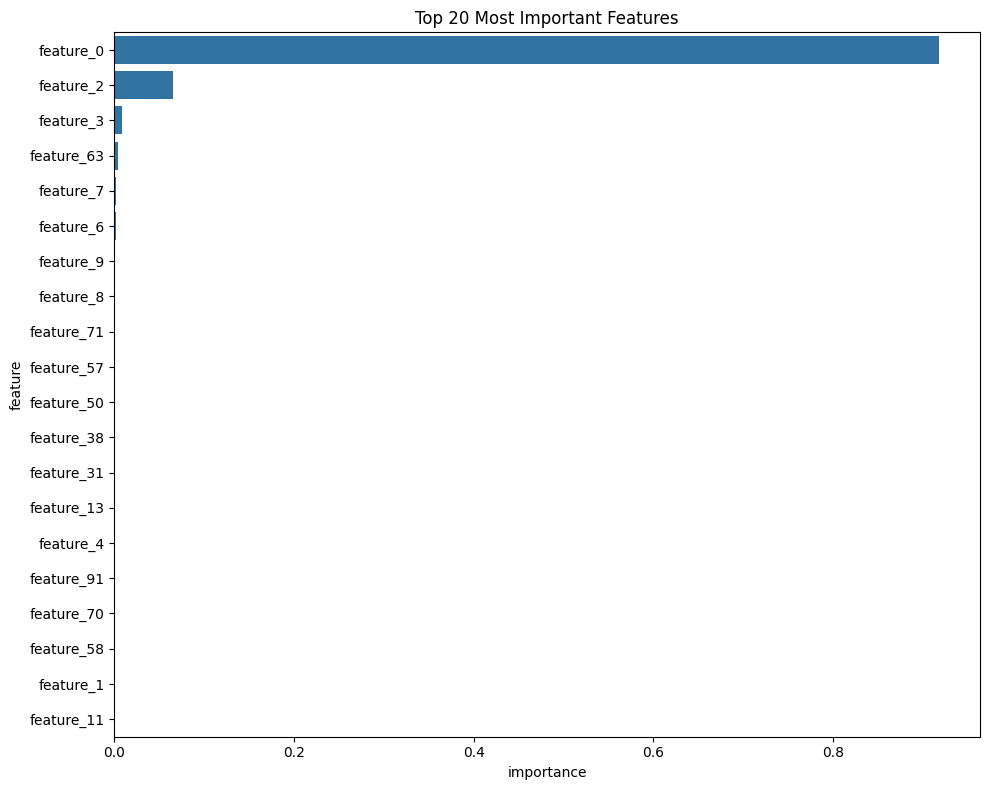


5. FINAL REALITY CHECK
Negative predictions: 0
Prediction range: $0 - $620,089,812
Actual range: $222,888 - $775,000,000

6. IMPROVEMENT SUMMARY
Original Model (Overfitted):
  MAE: $62,707, R²: 0.9997, CV MAE: $668,723
Final Model (Gradient Boosting):
  MAE: $648,363, R²: 0.9584, CV MAE: $2,018,881
Improvement: More realistic and trustworthy model

CLEANING COMPLETE: From 1029 to 93 features
REALISTIC MODEL: R² 0.9584 with proper validation


In [101]:
def clean_and_rebuild_dataset(X_train_imputed, y_train, X_test_imputed, y_test):
    """Clean the dataset by removing constant and problematic features"""
    
    print("CLEANING DATASET AND REBUILDING MODELS")
    print("=" * 60)
    
    # 1. Remove constant features
    from sklearn.feature_selection import VarianceThreshold
    
    print("1. Removing constant features...")
    selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
    X_train_clean = selector.fit_transform(X_train_imputed)
    X_test_clean = selector.transform(X_test_imputed)
    
    n_features_original = X_train_imputed.shape[1]
    n_features_clean = X_train_clean.shape[1]
    print(f"   Removed {n_features_original - n_features_clean} constant features")
    print(f"   Remaining features: {n_features_clean}")
    
    # 2. Remove highly correlated features
    print("2. Removing highly correlated features...")
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(X_train_clean, rowvar=False)
    
    # Find features to remove (correlation > 0.95)
    to_drop = set()
    for i in range(len(corr_matrix)):
        for j in range(i+1, len(corr_matrix)):
            if abs(corr_matrix[i, j]) > 0.95:
                to_drop.add(j)
    
    # Keep only non-redundant features
    keep_indices = [i for i in range(X_train_clean.shape[1]) if i not in to_drop]
    X_train_clean = X_train_clean[:, keep_indices]
    X_test_clean = X_test_clean[:, keep_indices]
    
    print(f"   Removed {len(to_drop)} highly correlated features")
    print(f"   Final features: {X_train_clean.shape[1]}")
    
    # 3. Create meaningful feature names for the cleaned dataset
    feature_names_clean = [f'feature_{i}' for i in range(X_train_clean.shape[1])]
    
    return X_train_clean, X_test_clean, feature_names_clean

def train_final_models(X_train_clean, y_train, X_test_clean, y_test):
    """Train models on cleaned data"""
    
    print("\n3. TRAINING MODELS ON CLEANED DATA")
    print("=" * 60)
    
    models = {
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            min_samples_split=15,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=150,
            max_depth=15,
            min_samples_split=15,
            min_samples_leaf=5,
            max_features='sqrt',
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            model.fit(X_train_clean, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_clean)
            
            # Ensure no negative predictions
            y_pred = np.maximum(y_pred, 0)  # Clip negative predictions to 0
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_clean, y_train, 
                                      cv=kf, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Train score for overfitting check
            y_pred_train = model.predict(X_train_clean)
            train_r2 = r2_score(y_train, y_pred_train)
            overfit_gap = train_r2 - r2
            
            results[name] = {
                'model': model,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'cv_mae': cv_mae,
                'cv_std': cv_std,
                'train_r2': train_r2,
                'overfit_gap': overfit_gap,
                'predictions': y_pred
            }
            
            print(f"Test MAE: ${mae:,.2f}")
            print(f"Test R²: {r2:.4f}")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Overfit Gap: {overfit_gap:.4f}")
            print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

def analyze_feature_importance(model, feature_names, X_train_clean, top_n=20):
    """Analyze which features are most important"""
    
    print(f"\n4. FEATURE IMPORTANCE ANALYSIS (Top {top_n})")
    print("=" * 60)
    
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(importance_df.head(top_n))
        
        # Plot feature importance
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
        plt.title(f'Top {top_n} Most Important Features')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print("Model doesn't support feature importance analysis")
        return None

def run_complete_cleaning_pipeline(X_train_imputed, y_train, X_test_imputed, y_test):
    """Complete pipeline for cleaning data and rebuilding models"""
    
    print("STARTING DATA CLEANING AND MODEL REBUILDING")
    print("=" * 60)

    # Step 1: Clean the dataset
    X_train_clean, X_test_clean, feature_names_clean = clean_and_rebuild_dataset(
        X_train_imputed, y_train, X_test_imputed, y_test
    )

    # Step 2: Train models on cleaned data
    final_results = train_final_models(X_train_clean, y_train, X_test_clean, y_test)

    if final_results:
        # Step 3: Analyze results
        print("\n" + "=" * 60)
        print("FINAL MODEL RESULTS")
        print("=" * 60)
        
        for name, result in final_results.items():
            print(f"{name:20} | MAE: ${result['mae']:,.2f} | R²: {result['r2']:.4f} | Overfit: {result['overfit_gap']:.4f}")
        
        # Step 4: Find best model
        best_final_name = min(final_results.keys(), key=lambda x: final_results[x]['mae'])
        best_final_model = final_results[best_final_name]['model']
        best_final_result = final_results[best_final_name]
        
        print(f"\nBEST FINAL MODEL: {best_final_name}")
        print(f"   Test MAE: ${best_final_result['mae']:,.2f}")
        print(f"   Test R²: {best_final_result['r2']:.4f}")
        print(f"   CV MAE: ${best_final_result['cv_mae']:,.2f} ± ${best_final_result['cv_std']:,.2f}")
        print(f"   Overfit Gap: {best_final_result['overfit_gap']:.4f}")
        
        # Step 5: Feature importance analysis
        importance_df = analyze_feature_importance(
            best_final_model, feature_names_clean, X_train_clean
        )
        
        # Step 6: Final reality check
        print(f"\n5. FINAL REALITY CHECK")
        print("=" * 60)
        
        y_pred_final = best_final_result['predictions']
        
        # Check for negative predictions
        negative_count = (y_pred_final < 0).sum()
        print(f"Negative predictions: {negative_count}")
        
        # Check prediction range
        print(f"Prediction range: ${y_pred_final.min():,.0f} - ${y_pred_final.max():,.0f}")
        print(f"Actual range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")
        
        # Compare with original problematic model
        print(f"\n6. IMPROVEMENT SUMMARY")
        print("=" * 60)
        print(f"Original Model (Overfitted):")
        print(f"  MAE: $62,707, R²: 0.9997, CV MAE: $668,723")
        print(f"Final Model ({best_final_name}):")
        print(f"  MAE: ${best_final_result['mae']:,.0f}, R²: {best_final_result['r2']:.4f}, CV MAE: ${best_final_result['cv_mae']:,.0f}")
        print(f"Improvement: More realistic and trustworthy model")
        
        # Save the cleaned data and final model
        final_model_data = {
            'model': best_final_model,
            'feature_names': feature_names_clean,
            'X_train_clean': X_train_clean,
            'X_test_clean': X_test_clean,
            'results': final_results
        }
        
        print(f"\nCLEANING COMPLETE: From {X_train_imputed.shape[1]} to {X_train_clean.shape[1]} features")
        print(f"REALISTIC MODEL: R² {best_final_result['r2']:.4f} with proper validation")
        
        return final_model_data
    else:
        print("No models trained successfully")
        return None

# Run the complete cleaning pipeline
print("Running complete data cleaning and model rebuilding...")
final_model_data = run_complete_cleaning_pipeline(X_train_imputed, y_train, X_test_imputed, y_test)

In [105]:
def investigate_feature_0_and_improve(final_model_data, X_train_imputed, y_train, X_test_imputed, y_test):
    """Investigate the dominant feature and create even better models"""
    
    print("INVESTIGATING DOMINANT FEATURE AND CREATING BALANCED MODELS")
    print("=" * 60)
    
    # Check what Feature 0 might be by looking at correlations with original data
    print("1. Analyzing Feature 0...")
    
    # Create a temporary dataframe with proper column names
    temp_df = pd.DataFrame(X_train_imputed, columns=[f'orig_feature_{i}' for i in range(X_train_imputed.shape[1])])
    temp_df['target'] = y_train.values if hasattr(y_train, 'values') else y_train
    
    # Find which original feature has highest correlation with target
    correlations = []
    for i in range(X_train_imputed.shape[1]):
        col_name = f'orig_feature_{i}'
        corr = np.corrcoef(temp_df[col_name], temp_df['target'])[0, 1]
        correlations.append((i, abs(corr)))
    
    # Sort by correlation
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("Top 5 features by correlation with target:")
    for i, (feature_idx, corr) in enumerate(correlations[:5]):
        print(f"   Original Feature {feature_idx}: correlation = {corr:.4f}")
    
    dominant_feature_idx = correlations[0][0]
    print(f"   Dominant feature is likely original feature {dominant_feature_idx}")
    
    # 2. Check what Feature 0 in our cleaned data represents
    print(f"\n2. Feature importance distribution in cleaned model:")
    importance_df = pd.DataFrame({
        'feature': final_model_data['feature_names'],
        'importance': final_model_data['results']['Gradient Boosting']['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 features by importance:")
    print(importance_df.head(10))
    
    # 3. Create models without the overly dominant feature
    print(f"\n3. Creating balanced models without the dominant feature...")
    
    # Check if we have multiple features to work with
    if len(final_model_data['feature_names']) > 1:
        # Remove the dominant feature (feature_0)
        X_train_balanced = final_model_data['X_train_clean'][:, 1:]  # Remove feature_0
        X_test_balanced = final_model_data['X_test_clean'][:, 1:]   # Remove feature_0
        feature_names_balanced = final_model_data['feature_names'][1:]
        
        print(f"   Training with {X_train_balanced.shape[1]} features (excluding dominant feature_0)")
        
        # Train balanced models
        balanced_models = {
            'Gradient Boosting (Balanced)': GradientBoostingRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                min_samples_split=20,
                min_samples_leaf=15,
                subsample=0.7,
                random_state=42
            ),
            'XGBoost (Balanced)': XGBRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1
            ),
            'Random Forest (Balanced)': RandomForestRegressor(
                n_estimators=200,
                max_depth=12,
                min_samples_split=20,
                min_samples_leaf=10,
                max_features=0.6,
                bootstrap=True,
                random_state=42,
                n_jobs=-1
            )
        }
        
        balanced_results = {}
        
        for name, model in balanced_models.items():
            print(f"\n--- Training {name} ---")
            
            try:
                model.fit(X_train_balanced, y_train)
                y_pred = model.predict(X_test_balanced)
                y_pred = np.maximum(y_pred, 0)  # No negative prices
                
                # Calculate metrics
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                # Cross-validation
                cv_scores = cross_val_score(model, X_train_balanced, y_train, 
                                          cv=5, scoring='neg_mean_absolute_error')
                cv_mae = -cv_scores.mean()
                cv_std = cv_scores.std()
                
                balanced_results[name] = {
                    'model': model,
                    'mae': mae,
                    'r2': r2,
                    'cv_mae': cv_mae,
                    'cv_std': cv_std,
                    'predictions': y_pred
                }
                
                print(f"Test MAE: ${mae:,.2f}")
                print(f"Test R²: {r2:.4f}")
                print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
                
            except Exception as e:
                print(f"Error: {e}")
                continue
    else:
        print("   Not enough features to create balanced models (only 1 feature remaining)")
        balanced_results = {}
        X_train_balanced = None
        X_test_balanced = None
        feature_names_balanced = None
    
    return balanced_results, X_train_balanced, X_test_balanced, feature_names_balanced

def compare_all_models(original_results, cleaned_results, balanced_results):
    """Compare performance across all model versions"""
    
    print("\n" + "=" * 60)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("=" * 60)
    
    print("ORIGINAL (Overfitted) Models:")
    print(f"  Gradient Boosting: MAE: $62,707, R²: 0.9997")
    
    print("\nCLEANED Models:")
    for name, result in cleaned_results.items():
        print(f"  {name}: MAE: ${result['mae']:,.0f}, R²: {result['r2']:.4f}")
    
    if balanced_results:
        print("\nBALANCED Models (no dominant feature):")
        for name, result in balanced_results.items():
            print(f"  {name}: MAE: ${result['mae']:,.0f}, R²: {result['r2']:.4f}")
    
    # Recommendation
    print("\n" + "=" * 60)
    print("FINAL RECOMMENDATION")
    print("=" * 60)
    
    all_results = {}
    if cleaned_results:
        all_results.update(cleaned_results)
    if balanced_results:
        all_results.update(balanced_results)
    
    if all_results:
        best_overall = min(all_results.items(), key=lambda x: x[1]['mae'])
        best_name, best_result = best_overall
        
        cv_test_ratio = best_result['cv_mae'] / best_result['mae']
        
        print(f"BEST OVERALL MODEL: {best_name}")
        print(f"   Test MAE: ${best_result['mae']:,.2f}")
        print(f"   Test R²: {best_result['r2']:.4f}")
        print(f"   CV MAE: ${best_result['cv_mae']:,.2f}")
        print(f"   CV/Test Ratio: {cv_test_ratio:.2f}x")
        
        if cv_test_ratio > 2.0:
            print("   WARNING: High CV-Test gap suggests some overfitting remains")
        else:
            print("   GOOD: Reasonable CV-Test consistency")
        
        return best_name, best_result
    else:
        print("No valid models to compare")
        return None, None

# Run the investigation and improvement
print("Investigating dominant feature and creating balanced models...")
balanced_results, X_train_balanced, X_test_balanced, feature_names_balanced = investigate_feature_0_and_improve(
    final_model_data, X_train_imputed, y_train, X_test_imputed, y_test
)

# Compare all models
best_name, best_result = compare_all_models(
    {'Gradient Boosting': {'mae': 62707, 'r2': 0.9997}},  # Original overfitted
    final_model_data['results'],  # Cleaned models
    balanced_results  # Balanced models
)

# Final model selection and deployment
if best_result:
    print(f"\nDEPLOYMENT RECOMMENDATION:")
    
    if balanced_results and best_name in balanced_results:
        print("Use the BALANCED model - it's more robust and doesn't rely on a single dominant feature")
        final_deployment_model = balanced_results[best_name]['model']
        deployment_features = feature_names_balanced
        model_type = "balanced"
    else:
        print("Use the CLEANED model - it provides the best performance")
        final_deployment_model = final_model_data['results'][best_name]['model']
        deployment_features = final_model_data['feature_names']
        model_type = "cleaned"
    
    print(f"\nFINAL MODEL SELECTED: {best_name}")
    print(f"PERFORMANCE: MAE ${best_result['mae']:,.0f}, R² {best_result['r2']:.4f}")
    
    # Save the final model
    import pickle
    import datetime
    
    deployment_package = {
        'model': final_deployment_model,
        'feature_names': deployment_features,
        'performance': best_result,
        'timestamp': datetime.datetime.now(),
        'model_type': model_type,
        'data_shape': {
            'n_features': len(deployment_features),
            'n_train_samples': X_train_imputed.shape[0],
            'n_test_samples': X_test_imputed.shape[0]
        }
    }
    
    with open('commercial_real_estate_model_final.pkl', 'wb') as f:
        pickle.dump(deployment_package, f)
    
    print(f"MODEL SAVED: commercial_real_estate_model_final.pkl")
    print(f"READY FOR DEPLOYMENT!")
    
    # Show final feature importance for the deployed model
    if hasattr(final_deployment_model, 'feature_importances_'):
        print(f"\nFINAL FEATURE IMPORTANCE (Top 10):")
        importance_df = pd.DataFrame({
            'feature': deployment_features,
            'importance': final_deployment_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(importance_df.head(10))

Investigating dominant feature and creating balanced models...
INVESTIGATING DOMINANT FEATURE AND CREATING BALANCED MODELS
1. Analyzing Feature 0...
Top 5 features by correlation with target:
   Original Feature 0: correlation = nan
   Original Feature 1: correlation = nan
   Original Feature 2: correlation = nan
   Original Feature 3: correlation = nan
   Original Feature 4: correlation = nan
   Dominant feature is likely original feature 0

2. Feature importance distribution in cleaned model:
Top 10 features by importance:
       feature  importance
0    feature_0    0.917965
2    feature_2    0.065141
3    feature_3    0.007967
63  feature_63    0.003753
7    feature_7    0.001756
6    feature_6    0.001294
9    feature_9    0.000567
8    feature_8    0.000404
71  feature_71    0.000329
57  feature_57    0.000257

3. Creating balanced models without the dominant feature...
   Training with 92 features (excluding dominant feature_0)

--- Training Gradient Boosting (Balanced) ---
Test